In [68]:
from sunpy.net import Fido, hek2vso, attrs as a
import sunpy.map
from sunpy.time import parse_time
import sunpy.timeseries
import sunpy.data.sample
from sunpy.coordinates import frames, get_horizons_coord, get_body_heliographic_stonyhurst
from sunpy.coordinates import SphericalScreen
from sunpy.coordinates.utils import get_rectangle_coordinates

from astropy import units as u
from astropy.coordinates import SkyCoord, SkyOffsetFrame
from astropy.visualization import AsymmetricPercentileInterval, ImageNormalize, LogStretch, AsinhStretch
from scipy.interpolate import interp1d

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import dates

import os

In [69]:
lines = [94, 131, 171, 193, 211, 304, 335]
images = os.listdir('images')
aia_maps = {}
for l in lines:
    tmp = []
    for filename in images:
        if filename.find(f'{l}A') != -1:
            tmp.append(sunpy.map.Map(f'images/{filename}'))
    aia_maps[l] = sunpy.map.Map(tmp, sequence=True)


In [70]:
xs, ys = np.loadtxt('wang_points.csv')[::-1].T
xs

array([-164., -166., -167., -170., -171., -174., -176., -178., -181.,
       -184., -186., -187., -190., -193., -195., -197., -197., -198.,
       -200., -200., -201., -202., -203., -204., -206., -207., -209.,
       -211., -215., -219., -223., -227., -232., -237., -241., -245.,
       -248., -252., -253., -255., -258., -261., -262., -264., -265.,
       -267., -269.])

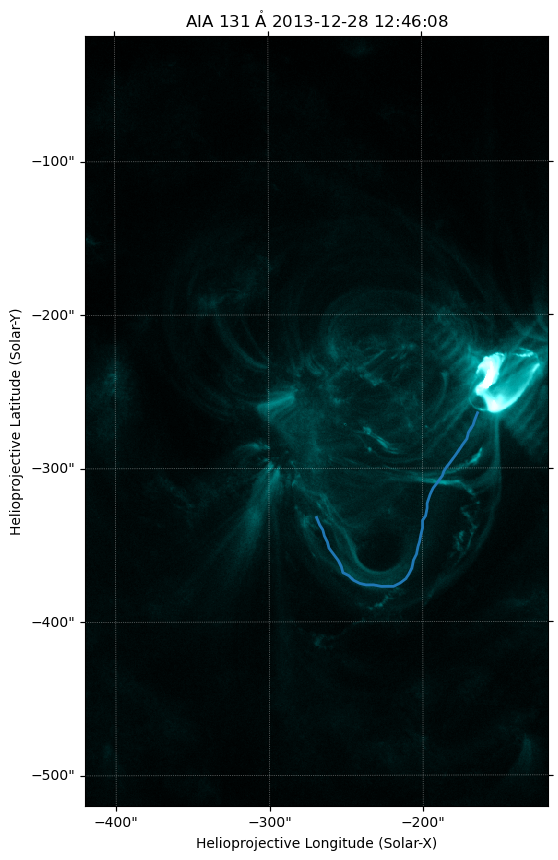

In [71]:
l = 131
n = 30
traced_loop = SkyCoord(
    Tx=xs*u.arcsec,
    Ty=ys*u.arcsec,
    frame=aia_maps[l][n].coordinate_frame,
)
fig = plt.figure(figsize=(6, 10))
ax = fig.add_subplot(projection=aia_maps[l][n])
aia_maps[l][n].plot()
ax.plot_coord(traced_loop, lw=2)

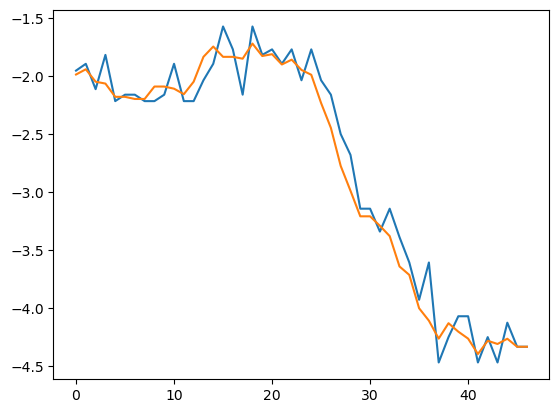

In [95]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

drs = np.zeros((2,len(xs)-1))
drs[0] = np.diff(np.array(xs))
drs[1] = np.diff(np.array(ys))
ts = [v/np.linalg.norm(v) for v in drs.T]
ts.append(ts[-1])
txs, tys = np.array(ts).T
preangles = np.arctan2(tys, txs)
preangles[np.argwhere(np.abs(np.diff(preangles))>np.pi)[0,0]+1:] = preangles[np.argwhere(np.abs(np.diff(preangles))>np.pi)[0,0]+1:]-2*np.pi
angles = np.append(moving_average(preangles), preangles[-2:])
plt.plot(preangles)
plt.plot(angles)

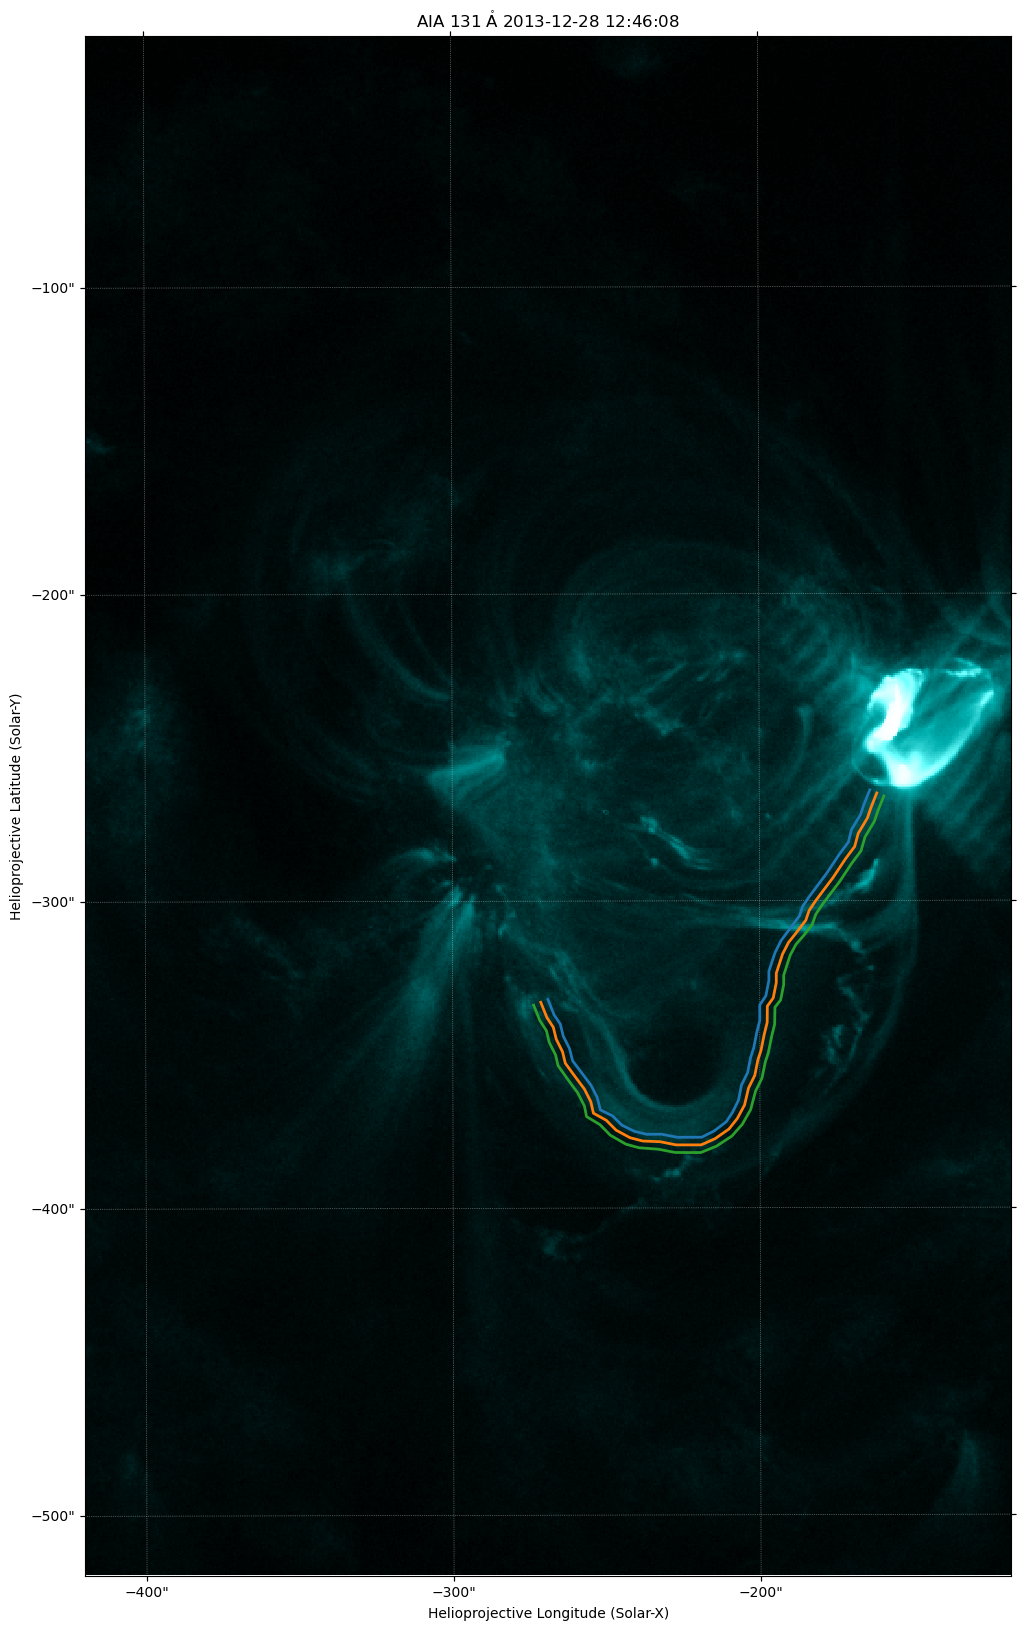

In [96]:
r1 = 2.5
r2 = 5
x1 = xs - r1*np.sin(angles)
y1 = ys + r1*np.cos(angles)
x2 = xs - r2*np.sin(angles)
y2 = ys + r2*np.cos(angles)

traced_loop_1 = SkyCoord(
    Tx=x1*u.arcsec,
    Ty=y1*u.arcsec,
    frame=aia_maps[l][n].coordinate_frame,
)
traced_loop_2 = SkyCoord(
    Tx=x2*u.arcsec,
    Ty=y2*u.arcsec,
    frame=aia_maps[l][n].coordinate_frame,
)
fig = plt.figure(figsize=(12, 20))
ax = fig.add_subplot(projection=aia_maps[l][n])
aia_maps[l][n].plot()
ax.plot_coord(traced_loop, lw=2)
ax.plot_coord(traced_loop_1, lw=2)
ax.plot_coord(traced_loop_2, lw=2)

In [97]:
width = np.round(np.mean(np.array([np.linalg.norm(v) for v in drs.T]))) * u.arcsec
height = 3 * width
rectangles = []
for i in range(len(preangles)):
    center_coord = SkyCoord(xs[i] * u.arcsec, ys[i] * u.arcsec, frame=aia_maps[l][n].coordinate_frame)
    offset_frame = SkyOffsetFrame(origin=center_coord, rotation=(-angles[i]*u.radian).to(u.degree))
    rectangles.append(SkyCoord(lon=[-1/2, 1/2] * width, lat=[-1/2, 1/2] * height, frame=offset_frame))

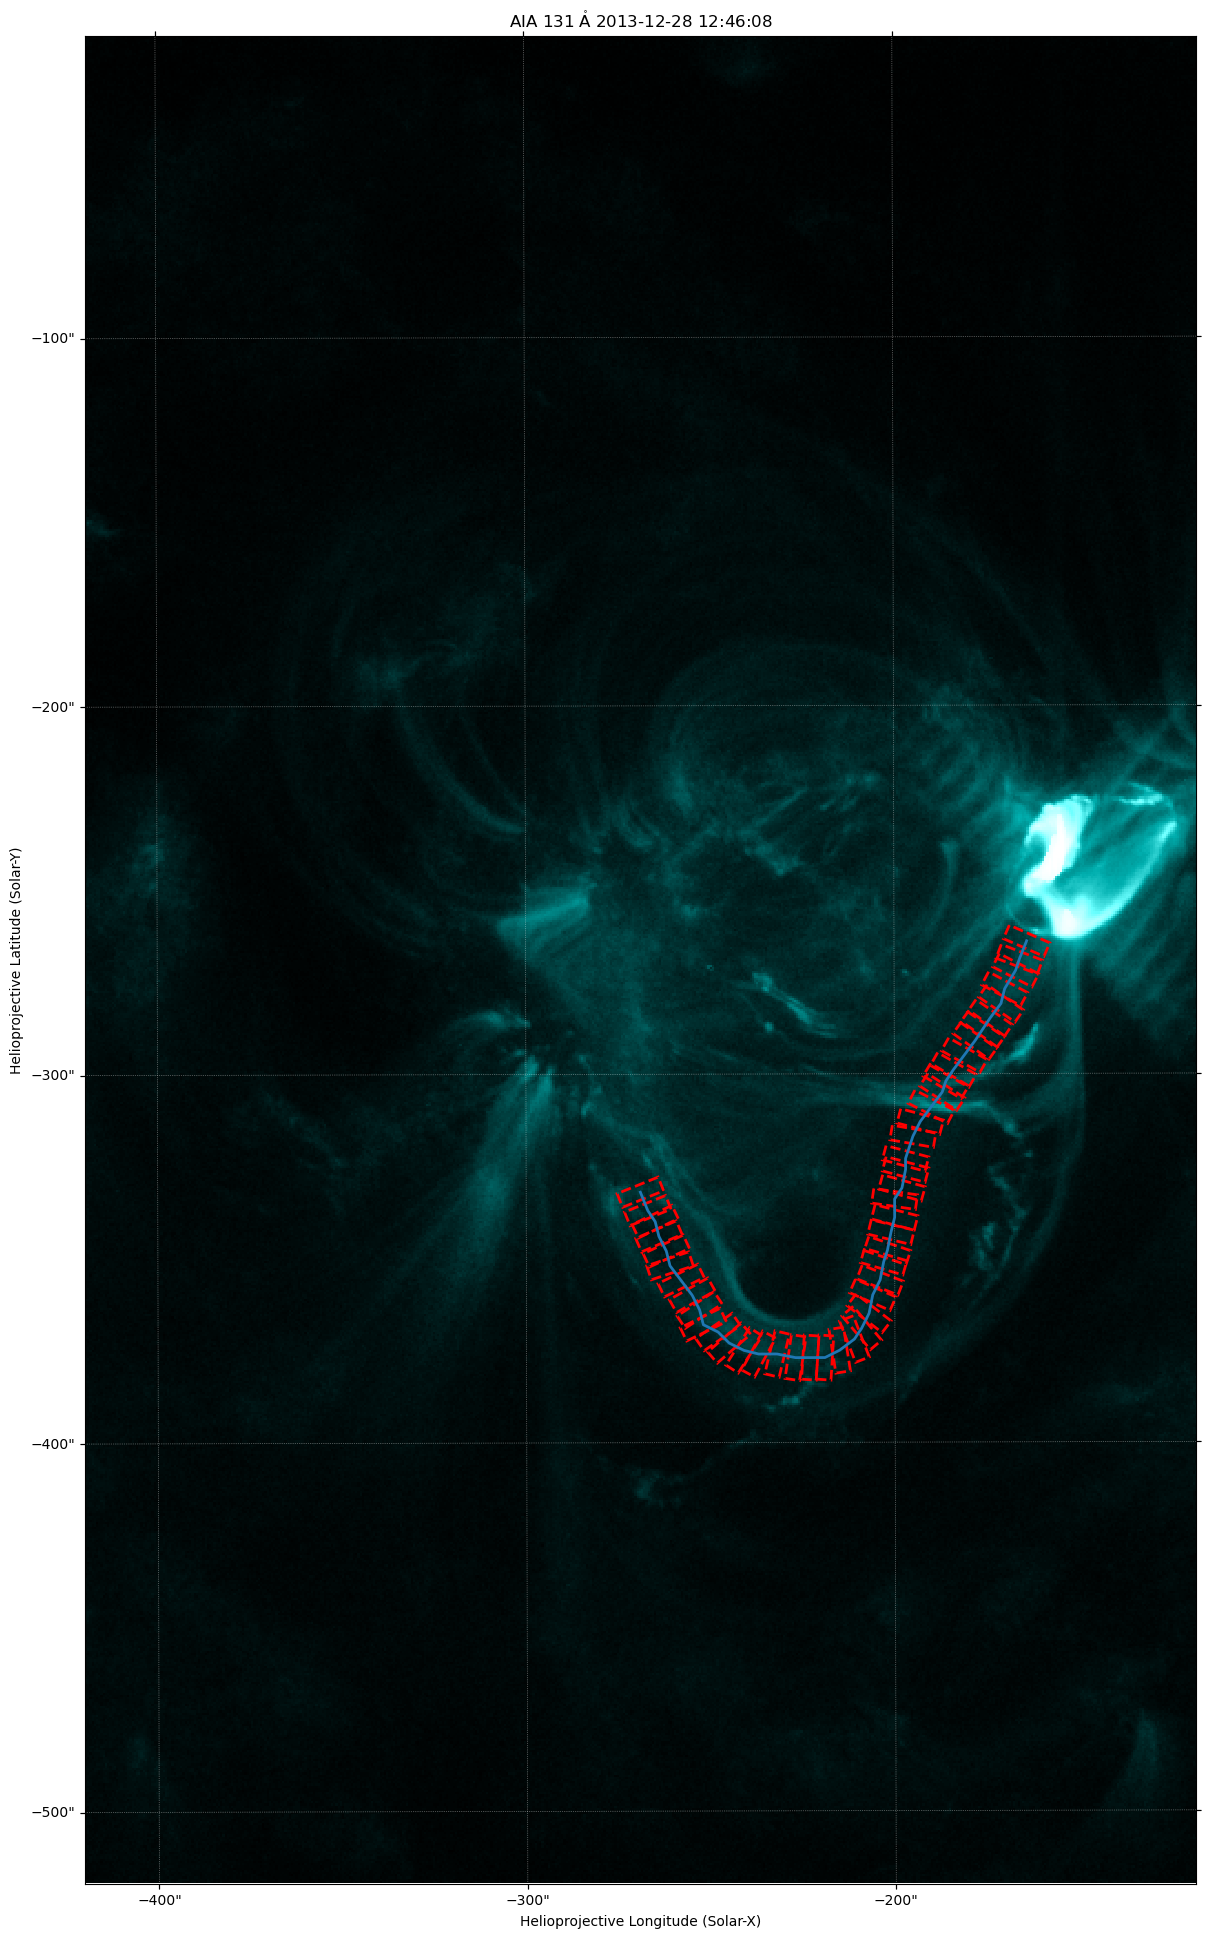

In [99]:
fig = plt.figure(figsize=(16, 24))
ax = fig.add_subplot(projection=aia_maps[l][n])
aia_maps[l][n].plot()
ax.plot_coord(traced_loop, lw=2)
for rec in rectangles:
    aia_maps[l][n].draw_quadrangle(
    rec,
    axes=ax,
    edgecolor="red",
    linestyle="--",
    linewidth=2,
)
plt.show()

In [100]:
traced_loop_distance = traced_loop.separation(traced_loop[0])
traced_loop_pixelated = sunpy.map.pixelate_coord_path(aia_maps[l][0], traced_loop)
traced_loop_detailed_distance = traced_loop_pixelated.separation(traced_loop_pixelated[0])
len(traced_loop_distance)

47

In [101]:
intensity_stack = {str(l): [] for l in lines}
for l in lines:
    for m in aia_maps[l]:
        with SphericalScreen(m.observer_coordinate):
            _recs_pixelated = [sunpy.map.pixelate_coord_path(m, rec) for rec in rectangles]
        intensity = np.array([np.mean(sunpy.map.sample_at_coords(m, rec).value) for rec in _recs_pixelated])
        f_interp = interp1d(traced_loop_distance.to_value('arcsec'), intensity, fill_value='extrapolate', kind='linear')
        intensity_interp = f_interp(traced_loop_detailed_distance.to_value('arcsec'))
        intensity_stack[str(l)].append(u.Quantity(intensity_interp, u.DN/u.second))
    intensity_stack[str(l)] = u.Quantity(intensity_stack[str(l)])

/tmp/ipykernel_18376/3307762327.py:6: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(time_array, distance.value, intensity_stack[str(l)].value.T,


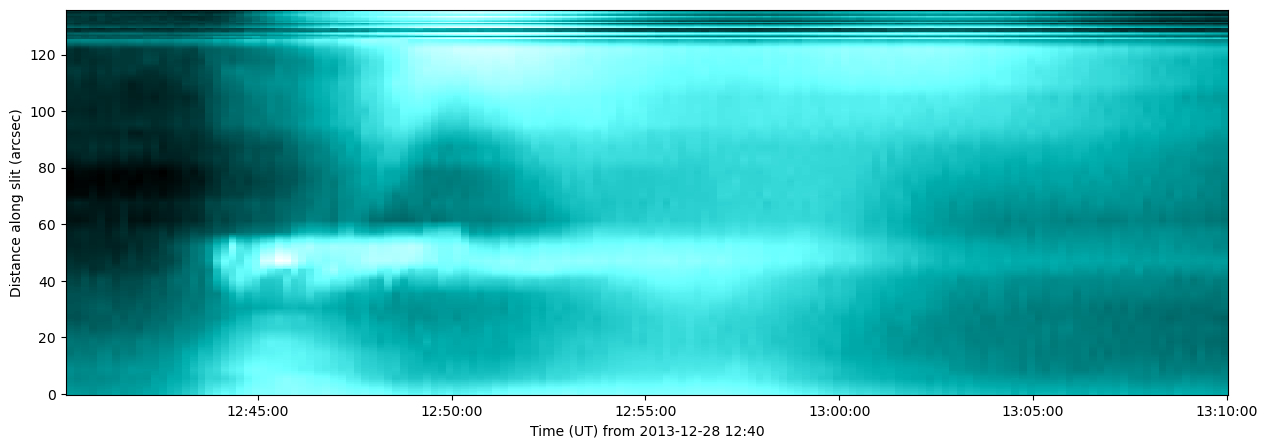

In [67]:
time_array = [m.date.datetime for m in aia_maps[l]]
distance = traced_loop_detailed_distance.to(u.arcsec)
l = lines[1]
# l = lines[0]
fig, ax = plt.subplots(figsize=(15, 5))
plt.pcolormesh(time_array, distance.value, intensity_stack[str(l)].value.T,
               norm=ImageNormalize(stretch=AsinhStretch()), cmap=f'sdoaia{l}')

ax.set_ylabel("Distance along slit (arcsec)")
ax.set_xlabel("Time (UT) from {:s}".format(time_array[0].strftime("%Y-%m-%d %H:%M")))
ax.xaxis.set_major_formatter(dates.DateFormatter("%H:%M:%S"))
plt.show()

intensity_stack['dist'] = distance.value
np.savez('results_avg_rect.npz', **intensity_stack)